In [34]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold


In [3]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

In [49]:
def load_data():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    X, y = dataset, labels
    X = X.astype('float32')

    # split into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # random split
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # n_features = (X_train.shape[1], X_train.shape[2])
    # print(n_features)
    # return X_train, X_test, y_train, y_test

    return X, y

def create_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=n_features))
    model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # fit the model
    model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test Accuracy: %.3f' % acc)

    # make predictions
    predictions = model.predict_classes(X)
    predictions = predictions.flatten()
    model.summary()
    return predictions

def get_faulty_predictions(predictions, labels):
    faulty_predictions = []
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            faulty_predictions.append(i)
    return faulty_predictions

- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

# Main

In [52]:
X, y = load_data()
skf = StratifiedKFold(n_splits=5, shuffle=True)

faulty_predictions = []

for train_index, test_index in skf.split(X, y):
		print(len(X[test_index]), len(y[train_index]))
		print("Running Fold", i+1, "/", n_folds)
		model = None # clear the NN
		model = create_model()
		predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])
		faulty_predictions.append(get_faulty_predictions(predictions, y))

240 960
Running Fold 1200 / 10
Test Accuracy: 0.992
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 20480)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 25)                512025    
_________________________________________________________________
dense_64 (Dense)             (None, 8)                 208       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 9         
Total params: 512,242
Trainable params: 512,242
Non-trainable params: 0
_________________________________________________________________
240 960
Running Fold 1200 / 10
Test Accuracy: 0.996
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape           

Errors in print statement above: "Running Fold" should display 1/5, 2/5, etc.

18


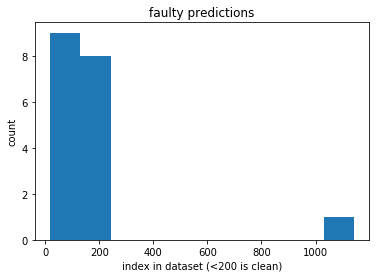

In [70]:

from itertools import chain
print(len(faulty_predictions))

plt.hist(faulty_predictions)
plt.xlabel("index in dataset (<200 is clean)")
plt.ylabel("count")
plt.title("faulty predictions")
plt.show()
